# Введение в обработку естественного языка

## Урок 2. Создание признакового пространства

Данные:

https://disk.yandex.ru/i/v5HM-ENiGXZVpQ

https://disk.yandex.ru/i/koR5eMCToCZS2Q

Задание 1.
Задание: обучите три классификатора:

1) на токенах с высокой частотой

2) на токенах со средней частотой

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Задание 2.
найти фичи с наибольшей значимостью, и вывести их

Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

Задание 1.

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

nltk.download('punkt', quiet=True)

# Отключить вывод ошибок
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive._append(negative)

In [3]:
def delete_pattern(text, pattern):
  return re.sub(pattern, ' ', text)

In [4]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [5]:
def reg_sub(x, pattern, sub_to = ''):
    regs = re.findall(pattern, x)
    for reg in regs:
        x = re.sub(reg, sub_to, x)
    return x

x = np.vectorize(reg_sub)

df['text'] = x(df['text'], "htt[\w]*")
df['text'] = x(df['text'], "@[\w]*")
df['text'] = x(df['text'], "#[\w]*")

In [6]:
# Замена пунктуации на пробелы
pattern_for_punctuation = r'[^\w\s]'
df['text'] = df['text'].apply(lambda x: delete_pattern(x, pattern_for_punctuation))
# Замена спец. символов на пробелы 
#pattern_for_special_symb = r'[^a-zA-Z0-9]'
#df['text'] = df['text'].apply(lambda x: delete_pattern(x, pattern_for_special_symb))
# Замена чисел на пробелы 
#pattern_for_numbers = r'[^a-zA-Z]'
#df['text'] = df['text'].apply(lambda x: delete_pattern(x, pattern_for_numbers))
# Удаление лишних пробелов
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()))

In [7]:
df['text']

0         хоть я и школота но поверь у нас то же самое d...
1         да все таки он немного похож на него но мой ма...
2                     rt ну ты идиотка я испугалась за тебя
3         rt кто то в углу сидит и погибает от голода а ...
4         вот что значит страшилка d но блин посмотрев в...
                                ...                        
111918    но не каждый хочет что то исправлять t co qnod...
111919    скучаю так только вправляет мозги но я все рав...
111920              вот и в школу в говно это идти уже надо
111921                          rt тауриэль не грусти обнял
111922    такси везет меня на работу раздумываю приплати...
Name: text, Length: 226834, dtype: object

In [8]:
# Слишком много времени занимает
# from pymystem3 import Mystem
# m = Mystem()

# def get_lemmatizer_list(s):
#     ' '.join(m.lemmatize(s))
#     return s

# x = np.vectorize(get_lemmatizer_list)
# df['text'] = x(df['text'])

In [9]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def delete_words_by_len(s, length = 1):
    return ' '.join([w for w in s.split() if len(w)>length])

x = np.vectorize(delete_words_by_len)
df['text'] = x(df['text'], length = 1)

In [11]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2330523


['хоть',
 'школота',
 'но',
 'поверь',
 'нас',
 'то',
 'же',
 'самое',
 'общество',
 'профилирующий']

In [12]:
df.label.value_counts()

label
positive    114911
negative    111923
Name: count, dtype: int64

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [14]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
y_train_word = y_train.copy()
y_train = [1 if elem == 'positive' else 0 for elem in y_train]
y_test_word = y_test.copy()
y_test = [1 if elem == 'positive' else 0 for elem in y_test]

In [16]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 75024),
 ('на', 38186),
 ('rt', 37359),
 ('что', 36097),
 ('co', 33036),
 ('как', 23561),
 ('меня', 21873),
 ('то', 20881),
 ('это', 19820),
 ('так', 19109)]

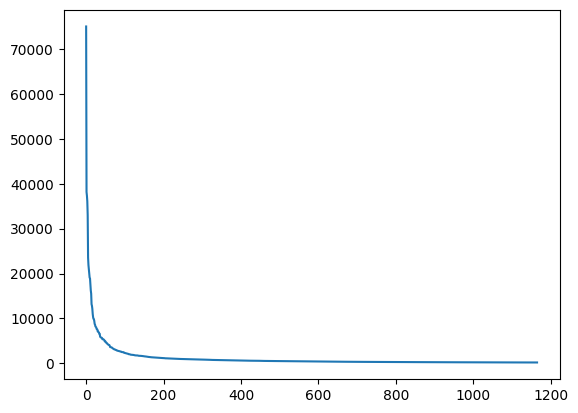

In [17]:
high_freqs = [freq for word, freq in freq_dict_sorted if freq>200]
plt.plot(high_freqs)
plt.show()

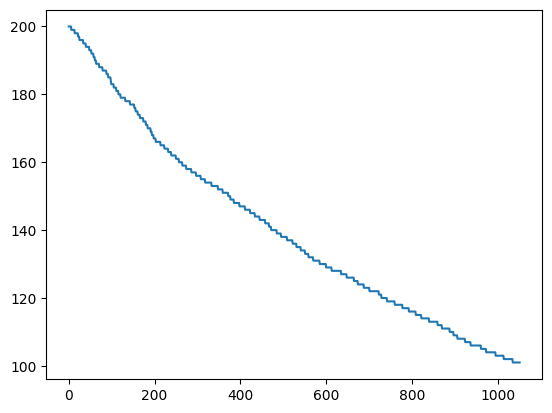

In [18]:
low_freq = [freq for word, freq in freq_dict_sorted if freq <= 200 and freq > 100]
plt.plot(low_freq)
plt.show()

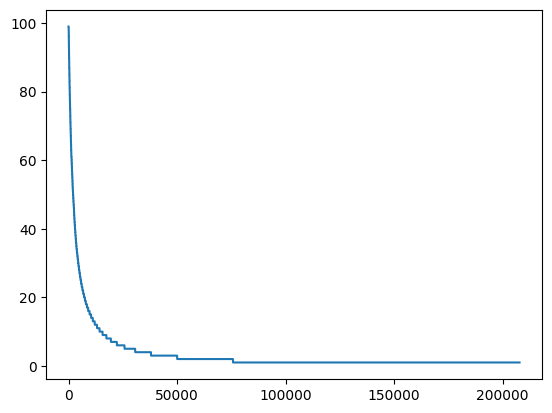

In [19]:
very_low_freq = [freq for word, freq in freq_dict_sorted if freq < 100]
plt.plot(very_low_freq)
plt.show()

In [20]:
len(freq_dict_sorted)

210063

In [21]:
len(high_freqs), len(low_freq), len(very_low_freq)

(1166, 1052, 207829)

In [23]:
vectorizer_high_freq = TfidfVectorizer(vocabulary=list(dict(freq_dict_sorted[:len(high_freqs)]).keys()))

# Создаем the Bag-of-Words модель
bag_of_words_high_freq = vectorizer_high_freq.fit_transform(x_train.values)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_high_freq = vectorizer_high_freq.get_feature_names_out()
df_high_freq_train = pd.DataFrame(bag_of_words_high_freq.toarray(), columns = feature_names_high_freq)
bag_of_words_high_freq_test = vectorizer_high_freq.transform(x_test.values)
df_high_freq_test = pd.DataFrame(bag_of_words_high_freq_test.toarray(), columns = feature_names_high_freq)

In [26]:
classifier_high_freq = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_high_freq.fit(df_high_freq_train, y_train)
predictions_high_freq_train = classifier_high_freq.predict(df_high_freq_train)
predictions_high_freq_test = classifier_high_freq.predict(df_high_freq_test)

In [27]:
print(classification_report(predictions_high_freq_train, y_train))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69     79603
           1       0.73      0.70      0.72     90522

    accuracy                           0.71    170125
   macro avg       0.70      0.71      0.70    170125
weighted avg       0.71      0.71      0.71    170125



In [28]:
print(classification_report(predictions_high_freq_test, y_test))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     26636
           1       0.73      0.69      0.71     30073

    accuracy                           0.70     56709
   macro avg       0.70      0.70      0.70     56709
weighted avg       0.70      0.70      0.70     56709



In [29]:
vectorizer_low_freq = TfidfVectorizer(vocabulary=list(dict(freq_dict_sorted[len(high_freqs):len(low_freq)+len(high_freqs)]).keys()))

# Создаем the Bag-of-Words модель
bag_of_words_low_freq = vectorizer_low_freq.fit_transform(x_train.values)

# Отобразим Bag-of-Words модель как DataFrame
feature_names_low_freq = vectorizer_low_freq.get_feature_names_out()
df_low_freq_train = pd.DataFrame(bag_of_words_low_freq.toarray(), columns = feature_names_low_freq)
bag_of_words_low_freq_test = vectorizer_low_freq.transform(x_test.values)
df_low_freq_test = pd.DataFrame(bag_of_words_low_freq_test.toarray(), columns = feature_names_low_freq)

In [30]:
classifier_low_freq = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_low_freq.fit(df_low_freq_train, y_train)
predictions_low_freq_train = classifier_low_freq.predict(df_low_freq_train)
predictions_low_freq_test = classifier_low_freq.predict(df_low_freq_test)

In [31]:
print(classification_report(predictions_low_freq_train, y_train))

              precision    recall  f1-score   support

           0       0.27      0.65      0.38     34786
           1       0.86      0.55      0.67    135339

    accuracy                           0.57    170125
   macro avg       0.56      0.60      0.52    170125
weighted avg       0.74      0.57      0.61    170125



In [32]:
print(classification_report(predictions_low_freq_test, y_test))

              precision    recall  f1-score   support

           0       0.26      0.63      0.37     11524
           1       0.85      0.54      0.66     45185

    accuracy                           0.56     56709
   macro avg       0.56      0.59      0.51     56709
weighted avg       0.73      0.56      0.60     56709



Сравнил токенты с высокой частотой по сравнению со средней частотой, можно предположить что токены с высокой частотой более важны, но с увеличением числа токенов со средней частотой их точность будет выравниваться.

In [40]:
words=[word for word in freq_dict.keys()]
words

['хоть',
 'школота',
 'но',
 'поверь',
 'нас',
 'то',
 'же',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'да',
 'все',
 'таки',
 'он',
 'немного',
 'похож',
 'на',
 'него',
 'мой',
 'мальчик',
 'равно',
 'лучше',
 'rt',
 'ну',
 'ты',
 'идиотка',
 'испугалась',
 'за',
 'тебя',
 'кто',
 'углу',
 'сидит',
 'погибает',
 'от',
 'голода',
 'мы',
 'ещё',
 'порции',
 'взяли',
 'хотя',
 'уже',
 'так',
 'жрать',
 'не',
 'хотим',
 'dd',
 'co',
 'gqg6iue2',
 'вот',
 'что',
 'значит',
 'страшилка',
 'блин',
 'посмотрев',
 'части',
 'создастся',
 'ощущение',
 'авторы',
 'курили',
 'любишь',
 'или',
 'нет',
 'знаю',
 'бля',
 'brf9eng1u6',
 'ох',
 '900',
 'это',
 'конечно',
 'чтобы',
 'нее',
 'было',
 'много',
 'друзей',
 'ведь',
 'она',
 'такая',
 'мимими',
 'lt',
 'есть',
 'ухажёр',
 'мои',
 'уши',
 'жрёт',
 'поприветствуем',
 'моего',
 'нового',
 'читателя',
 'теперь',
 'меня',
 'частичка',
 'сиднея',
 'operahouse',
 'agnto3czei',
 'люблю',
 'маму',
 'папу',
 'остальное',
 'влюбл

In [41]:
count_vectorizer = CountVectorizer(vocabulary = words)
x_train_count = count_vectorizer.fit_transform(x_train.values)
x_test_count = count_vectorizer.transform(x_test.values)
classifier_count_vect = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_count_vect.fit(x_train_count, y_train)
predictions_train_count = classifier_count_vect.predict(x_train_count)
predictions_test_count = classifier_count_vect.predict(x_test_count)

In [42]:
print(classification_report(predictions_train_count, y_train))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     83770
           1       0.89      0.89      0.89     86355

    accuracy                           0.89    170125
   macro avg       0.89      0.89      0.89    170125
weighted avg       0.89      0.89      0.89    170125



In [43]:
print(classification_report(predictions_test_count, y_test))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     27990
           1       0.76      0.75      0.75     28719

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



In [44]:
tfidf_vectorizer = TfidfVectorizer(vocabulary = words)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train.values)
x_test_tfidf = tfidf_vectorizer.transform(x_test.values)
classifier_tfidf_vect = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier_tfidf_vect.fit(x_train_tfidf, y_train)
predictions_train_tfidf = classifier_tfidf_vect.predict(x_train_tfidf)
predictions_test_tfidf = classifier_tfidf_vect.predict(x_test_tfidf)

In [45]:
print(classification_report(predictions_train_tfidf, y_train))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     80248
           1       0.85      0.81      0.83     89877

    accuracy                           0.82    170125
   macro avg       0.82      0.82      0.82    170125
weighted avg       0.82      0.82      0.82    170125



In [46]:
print(classification_report(predictions_test_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     26160
           1       0.78      0.73      0.76     30549

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



In [47]:
n_features_for_hash = [2 ** i for i in range(18)]

In [48]:
for numb in n_features_for_hash:
    print('n_features =', numb)
    hash_vectorizer = HashingVectorizer(n_features=numb)
    x_train_hash = hash_vectorizer.fit_transform(x_train.values)
    x_test_hash = hash_vectorizer.transform(x_test.values)
    classifier_hash_vect = LogisticRegression(solver='lbfgs', max_iter=1000)
    classifier_hash_vect.fit(x_train_hash, y_train)
    predictions_train_hash = classifier_hash_vect.predict(x_train_hash)
    predictions_test_hash = classifier_hash_vect.predict(x_test_hash)
    print(classification_report(predictions_test_hash, y_test))
    print()

n_features = 1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67     56709

    accuracy                           0.50     56709
   macro avg       0.50      0.25      0.34     56709
weighted avg       1.00      0.50      0.67     56709


n_features = 2
              precision    recall  f1-score   support

           0       0.30      0.51      0.38     16600
           1       0.72      0.51      0.60     40109

    accuracy                           0.51     56709
   macro avg       0.51      0.51      0.49     56709
weighted avg       0.60      0.51      0.53     56709


n_features = 4
              precision    recall  f1-score   support

           0       0.41      0.52      0.46     21979
           1       0.63      0.52      0.57     34730

    accuracy                           0.52     56709
   macro avg       0.52      0.52      0.52     56709
weighted avg       0.55    

512 - оптимальный размер для hash vectorizer

In [59]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [63]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [64]:
train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [87]:
for raw in train_data.take(1):
    pass

In [89]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [96]:
def custom_standardization(input_data):
    
    return input_data

vocab_size = 10000
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [97]:
embedding_dim=200

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(200, (2)),
    GRU(300),
    #GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1)
])

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
model.fit(train_data, validation_data=valid_data, epochs=1)

10633/10633 [==============================] - 1853s 174ms/step - loss: 0.6931 - accuracy: 0.4927 - val_loss: 0.6931 - val_accuracy: 0.4954


0.4954 не особо хороший результат, т.к. примерно такой же результат дает, если все время называть позитивный коммент, нужны более сложные методы для обучения текста 